# Introduction to Density-Based Clustering

-----

The first type of clustering algorithm discussed in this course used the spatial distribution of points to determine cluster centers and membership. The most prominent implementation of this concept is the K-means cluster algorithm. This approach is conceptually simple and often fast, however, it requires knowledge of the number of clusters ahead of time. While there are automated methods for determining $k$ algorithmically, this requirement is still an impediment for some applications. An alternative, density-based clustering technique called [Density-Based Spatial Clustering of Applications with Noise (DBSCAN)][wdb] can be used instead. 

The DBSCAN algorithm has several advantages over the K-means algorithm. First, DBSCAN automatically determines the number of clusters within a data set. Second, since the DBSCAN algorithm is a density-based clustering algorithm, the discovered clusters can have arbitrary shapes. On the other hand, since the clusters and their membership are defined by the density, the hyperparameters used to specify the target density can dramatically affect the cluster determination. Thus, hyperparameter tuning may be required to achieve optimal results.

-----
[wdb]: https://en.wikipedia.org/wiki/DBSCAN

## Table of Contents

[Formalism](#Formalism)

[DBSCAN: Iris Data](#DBSCAN:-Iris-Data)

[Hyperparameter Estimation](#Hyperparameter-Estimation)
- [k-distance graph](#k-distance-graph)

[K-means vs. DBSCAN](#K-means-vs.-DBSCAN)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

DBSCAN is a density-based clustering algorithm, as opposed to spatial clustering algorithms such as K-means. Fundamentally, the DBSCAN algorithm operates by [classifying points][wdbcp]. 

This algorithm takes two critical hyperparameters: 
- `eps`(epsilon): The `eps` hyperparameter defines the maximum distance between two points for them to still be considered in the same  _density neighborhood_. 
- `min_samples`: The `min_samples` hyperparameter is the number of points that must lie within the neighborhood of the current point in order for it to be considered a _core point_. 

With the two hyperparameters defined, we can place data points in a dataset to three categories:

- Core point: A data point is a _core point_ if at least `min_samples` of points(including the point itself) are within a given distance `eps`.

- Border point: A data point that is not a core point, but within the distance of `eps` to at least one core point. A border point belongs to the cluster of the _closest_ core point.

- Noise point: A data point that is neither core point nor border point. Noise points don't belong to any cluster.

Two core points are _directly reachable_ if their distance is within `eps`.   
Two core points p and q are _reachable_ if there exists a path of core points, $p_1, p_2, ..., p_n$, where p is directly reachable to $p_1$, q is directly reachable to $p_n$ and each $p_i$ is directly reachable to $p_{i+1}$.

All core points that are reachable to each other form a cluster. All border points of these core points also belong to the cluster.


-----

[wdbcp]: https://en.wikipedia.org/wiki/DBSCAN#Preliminary

[[Back to TOC]](#Table-of-Contents)


## DBSCAN: Iris Data


We will use the standard Iris data set to explore the application of the DBSCAN clustering algorithm. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width. The data set consists of 150 total measurements of three different types of iris flowers, equally divided between three classes: Setosa, Versicolor, and Virginica. 

The following Code cell loads the Iris data into this notebook, and normalizes the four features to have zero mean and unit standard deviation by using a `StandardScaler` transformer. Next, the labels are extracted and encoded. Finally, the features are transformed to a two-dimensional space to simplify visualizations that use these data to aid in understanding how the DBSCAN algorithm performs.

-----

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the digits data
iris = pd.read_csv('iris.csv')
    
# standardize the features
x = StandardScaler().fit_transform(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
# encode species to get labels, this is for visulization only
y = LabelEncoder().fit_transform(iris.species)

In [3]:
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
x_pca = pca.fit_transform(x)

# append label to reduced dataset.
x_pca_label = np.concatenate((x_pca, y.reshape(x.shape[0], 1)), axis=1)

-----

With the data loaded into the notebook, we can now apply the DBSCAN algorithm to identify clusters. In the scikit-learn library, we use the [`DBSCAN`][skdb] estimator in the `cluster` module to perform DBSCAN clustering. This estimator takes a number of hyperparameters that affect its performance, including:

- `eps`: The maximum distance between two instances for them to be considered in the same neighborhood, the default is 0.5.
- `min_samples`: The number of instances in a neighborhood for a point to be considered a _core point_, the default is five.
- `metric`: The function used to compute distances between points, the default is `euclidean`.

Once the estimator has been created, we can use the `fit` method to determine the clusters. By default, this function creates a model attribute called `labels_` that contains the cluster label for each instance in the data set. Alternatively, the `fit_predict` method can be called, which also returns the label array. Two other model attributes computed during the fitting process are `core_sample_indices_`, which contain the indices of the core points within the instance array that was provided to the `fit` method, and  `components_`, which is an array consisting of the core points.

The following Code cell performs DBSCAN clustering with tuned values for the `eps` and `min_samples` hyperparameters. The output from this cell displays the number of core points (= 53) and the number of clusters (= 3). Note that the cluster label of negative one indicates the identified _noise points_.

-----

[skdb]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [4]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
db = DBSCAN(eps=0.575, min_samples=10)
db.fit(x)

print(f'Number of core points = {db.components_.shape[0]}')
print(f'Cluster labels: {np.unique(db.labels_)}')

Number of core points = 53
Cluster labels: [-1  0  1  2]


---
In the next Code cell, we calculate Adjusted Rand Index and Silhouette score for the DBSCAN model. We get the predicted clusters from the model's `labels_` attribute and use it to calculate the two metrics. Both metrics are lower than that from K-means clustering. This is understandable since with K-means, we tell the model more information which is the number of clusters.


In [5]:
from sklearn import metrics

y_pred = db.labels_
ars = metrics.adjusted_rand_score(y, y_pred)
ss = metrics.silhouette_score(x, y_pred)
print(f'Adjusted Rand Index for DBSCN:{ars:5.2f}')
print(f'Silhouette Score for DBSCAN:{ss:5.2f}')

Adjusted Rand Index for DBSCN: 0.53
Silhouette Score for DBSCAN: 0.25


-----

The core points are central to the completion of the DBSCAN algorithm. In the following Code cell, we plot the Iris data in the two principal components. We extract the core points, via the `components_` attribute on the DBSCAN model, and mark each of them in the plot with a purple x. Recall that a core point has `min_samples` other points within a distance `eps`. As shown in the following plot, the core points are all located in the highest density areas of the plot, which should make sense since the minimum sample was set to ten. These core points define the cores of each cluster found by the DBSCAN algorithm.

**Note:** You are not required to understand the code. Pay more attention to the plot.


-----

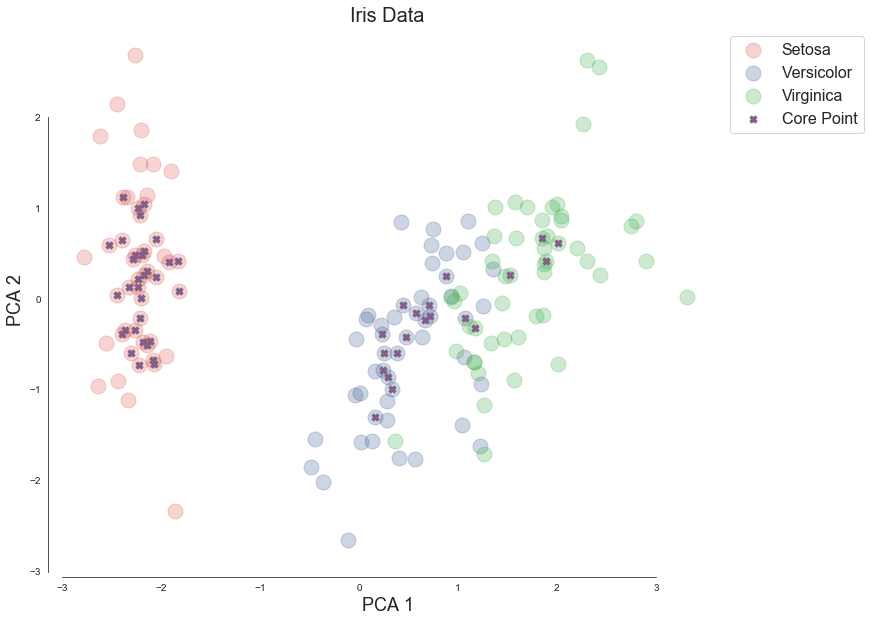

In [6]:
# Transform core points to PCA space
cp = pca.transform(db.components_)

# Colors used for plotting species
clr = [sns.xkcd_rgb["pale red"], 
       sns.xkcd_rgb["denim blue"], 
       sns.xkcd_rgb["medium green"]]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
cols = ['PCA1', 'PCA2', 'Species']

# Define data
dt = pd.DataFrame(x_pca_label, columns = cols)

# Make plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot three known clusters with true labels
for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], 
               color=clr[idx], label=lbls[idx], alpha=0.25, s=225)

# Plot core points
ax.scatter(cp[:, 0], cp[:, 1], label='Core Point',
           color=sns.xkcd_rgb['dusty purple'], 
           marker='X', alpha=1, s=50)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine(offset=5, trim=True)

-----

With the clusters identified, we can now explore the assignment of instances to each cluster. In the first Code cells below, we extract the cluster labels from the DBSCAN model. By using a Python `Counter` collection, we can quickly accumulate the number of instances in each cluster. The results indicate the first two clusters (roughly overlapping the Iris Setosa and the Iris Versicolor data) are each roughly the same size. However, the Iris Virginica is much smaller, with the bulk of the remaining points classified as noise.

In the second Code cell below, we visually explore the same concept. In this plot, we show the Iris instances as large, semitransparent circles, along with the cluster labels as smaller, darker points. This plot demonstrates that outlying members of each species are misclassified as noise, but that instances of Iris Virginica are also strongly misclassified as Iris Versicolor. Given the overlap between these two clusters, this is not surprising. The higher density core of the Iris Versicolor leads the unsupervised cluster finding to misidentify Iris Virginica.

**Note:** You are not required to understand the code. Pay more attention to the plot.

-----

In [7]:
from collections import Counter 
cnt =  Counter(np.sort(db.labels_))

# Display some basic results of the clustering
print('DBSCAN Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

DBSCAN Cluster membership.
------------------------------
Noise Cluster :   43 members
Cluster 0     :   45 members
Cluster 1     :   45 members
Cluster 2     :   17 members


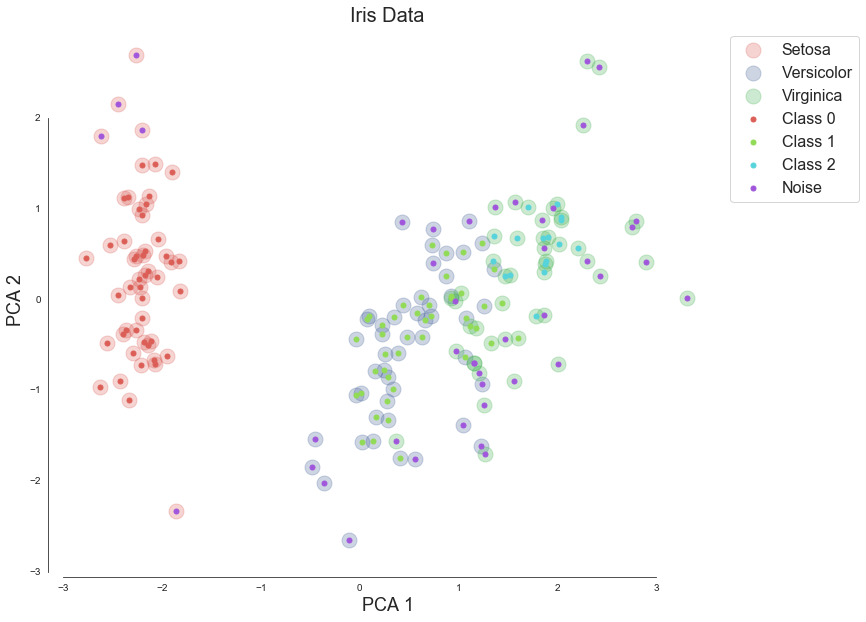

In [8]:
# Get cluster labels and assign plotting colors/labels.
dblbls = set(db.labels_)
dbclrs = sns.hls_palette(len(dblbls))
dbcls = [f'Class {idx}' if idx >= 0 else 'Noise' for idx in dblbls]

# Data
pc = pd.DataFrame(np.concatenate((x_pca, db.labels_.reshape((150, 1))), axis=1), 
                  columns = cols)

# Make plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot three known clusters
for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], 
               label=lbls[idx], alpha=0.25, s=225)

# Plot DBSCAN clusters (and noise)
for idx in list(dblbls):
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=dbclrs[idx], label=dbcls[idx], alpha=1, s=25)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the DBSCAN algorithm to cluster the Iris data. Now that you have run the Notebook, go back and make the following changes to see how the results change. 

1. Change the `eps` parameter in the DBSCAN algorithm and visualize the new clusters.
3. Change the `min_samples` parameter in the DBSCAN algorithm and visualize the new clusters.

Finally, can you explain why the different algorithms performed differently when the parameters changed?

-----

[[Back to TOC]](#Table-of-Contents)

## Hyperparameter Estimation

The values of DBSCAN hyperparameters have a huge impact on the performance of the algorithm. A too small `eps` results in many data points not clustered; A too-large `eps` will merge clusters and group majority of data points into one cluster. On the other hand, a too-small `min_samples` will include many noises into clusters (extreme case is when `min_samples`=1, every data point is a core point and there's no noise); a too large `min_samples` results a lot of noises.

- `min_samples`: A general rule is that, if there are D features in the dataset, `min_samples` should be greater than D. As a rule of thumb, `min_samples`= 2D. But larger values can be used for large data, or data with a lot of noises or duplicates.
- `eps`: In general, small values of `eps` are preferable, and as a rule of thumb, only a small fraction of points should be within this distance of each other. `eps` can be determined by k-distance graph.

---
### k-distance graph

To plot k-distance graph, we will first identify the nearest neighbor of each point. Then calculate the distance of every point to its nearest neighbor. These distances are then sorted in ascending order and plotted. The point where you see an elbow-like bend corresponds to the optimal *eps* value.

In the next Code cell, we plot k-distance graph for the Iris dataset. We use `NearestNeighbors` in scikit-learn to get nearest neighbors and distance information. Since the point itself is included as the first nearest neighbor, to get to the nearest neighbor that's not itself, we set `n_neighbors` to 2. We then get distances to nearest neighbors by using `NearestNeighbors` model's `kneighbors` function. Since `n_neighbors` is 2, each item in distances is a numpy array with 2 values, or distances to the nearest 2 data points. The first value is always 0 since it's the distance to itself. We will use the second value(`distances[:,1]`) to plot the k-distance graph. 

The elbow appears when distance is slightly below 0.6. This graph indicates that majority of the data points(close to 140) are within distance of 0.6 to their nearest neighbor. With `eps` set to a little below 0.6, the algorithm should be able to identify most data points to a cluster. Points that have distance greater than 0.6 to their nearest neighbor are likely to be identified as noise points.

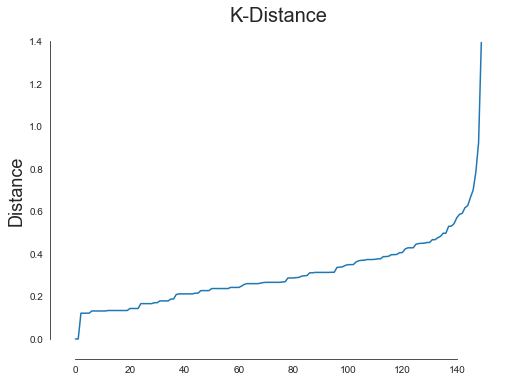

In [9]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

#get nearest neighbor of each points
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(x)

#calculate distances to the neighbor of each point
distances, indices = neigh.kneighbors(x)

#sort by distance from low to high and plot
fig, ax = plt.subplots(figsize=(8, 6))
distances = distances[:,1]
distances = np.sort(distances)
plt.plot(distances)
plt.title("K-Distance")
plt.ylabel("Distance")
sns.despine(offset=5, trim=True)

---
[[Back to TOC]](#Table-of-Contents)

## K-means vs. DBSCAN

K-means and DBSCAN work differently and can be used to solve different problems.

K-means works better if clusters in a dataset have spherical-like shapes. It always tries to construct a nice spherical shape around the centers. If the clusters have complicated geometric shapes, kmeans does a poor job in clustering the data. 

DBSCAN works well when the clusters don't have too much overlap and the clusters have similar density.

This will be demonstrated with two sample datasets below.  

The first dataset has clusters in spherical shapes, where each clusters can be determined by its center. K-means will be able to identify the clusters correctly for this dataset. 

The second dataset has two clusters which are in half-circle shape and entangled together. It's impossible to find two centers to identify the two clusters cleanly. In this case, DBSCAN will be able to identify the two clusters correctly since the data points in the same cluster are density reachable to each other.

#### K-means works well:
<img src='images/k_means_good.png' width=400>

#### K-means works poorly but DBSCAN works well:
<img src='images/dbscan_good.png' width=400>


A simple way to determine whether to use K-means or DBSCAN is through visualization. First use PCA to convert the dataset to a two-dimensional dataset. Then plot the dataset and visualize the shape of data points. Based on the PCA visualization we plotted in previous lesson, DBSCAN may not work well with credit card dataset since there is no clear separations among clusters and the density of the dataset varies at different location.

-----

<font color='red' size = '5'> Student Exercise </font>


In this lesson, we used the DBSCAN algorithm to cluster the Iris data set. Try using DBSCAN on the credit card dataset introduced in the previous lesson. Print out a count of each cluster found by DBSCAN. Is DBSCAN able to identify some meaningful clusters in the dataset?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. The scikit-learn discussion on [density based clustering][1]
1. A Python implementation of a related [HDBSCAN algorithm][2]
2. Blog article on [density based clustering][3]


-----

[1]: http://scikit-learn.org/stable/modules/clustering.html#dbscan
[2]: http://hdbscan.readthedocs.io/en/latest/
[3]: https://blog.dominodatalab.com/topology-and-density-based-clustering/

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 